This is similar to the N-gram model, with the difference being that this model counts occurences of N by N squares to predict the bottom right element. This gives the model some awareness of the spacial position of a pixel.

In [1]:
import numpy as np
import collections as co
import random as ra
import concurrent.futures
import functools as ft
import math as m
import matplotlib.pyplot as plt

tr = np.load("train.npy")
te = np.load("test.npy")

sq_int_tr = np.reshape(np.asarray(tr, dtype=np.int32), (len(tr), 28, 28))
sq_int_te = np.reshape(np.asarray(te, dtype=np.int32), (len(te), 28, 28))

In [2]:
# Counts occurrences for spacial model. Model uses N by N square of context to predict its bottom right corner pixel
# Data should be integers, no smaller than zero.
# No checking is done for the shape of data.
def count_spacial(N : int, data : np.ndarray) -> np.ndarray:
    special = np.max(data) + 1 # special symbol not in data set
    counts = np.zeros([special + 1] * (N ** 2), dtype=np.int32)
    padded = np.pad(data, ((0, 0), (N - 1, 0), (N - 1, 0)), constant_values=special)
    for (ix, iy, iz), val in np.ndenumerate(data):
        sub_matrix = padded[ix, iy : iy + N, iz : iz + N]
        counts[tuple(sub_matrix.flatten())] += 1 # assumes values are usable as indices, otherwise need a dictionary
    return counts

# count_spacial() but with parallel execution.
def parallel_count_spacial(N : int, data : np.ndarray, batches = 8) -> np.ndarray:
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(ft.partial(count_spacial, N), np.array_split(data, batches))
    return ft.reduce(np.add, results)

# Make counts into probabilities.
def normalize_spacial(arr : np.ndarray) -> np.ndarray:
    s = np.sum(arr, axis=-1, keepdims=True)
    s = np.where(s == 0, 1, s) # Prevent NaN in result. This is compatible with the sampling function.
    return arr / s

# Generate a sample from calculated weights.
def sample_spacial(weights : np.ndarray, shape) -> np.ndarray:
    special = len(weights) - 1
    N = int(m.sqrt(len(weights.shape)))
    symbols = list(range(special + 1))
    sample = special * np.ones(np.array(shape) + N - 1, dtype=np.int32) # fill with special, padded size
    for ix, iy in np.ndindex(shape):
        co_ords = sample[ix : ix + N, iy : iy + N].flatten()[:-1] # surrounding values. chop off current position as it's not valid yet
        ws = weights[tuple(co_ords)]
        if np.sum(ws) == 0:
            ws = [1] * special + [0] # no data, select equiprobably except for special symbol
        sample[ix + N - 1, iy + N - 1] = ra.choices(symbols, ws)[0]
    return sample[N - 1:, N - 1:]

# Compute mean log liklihood of a data set given the model
def log_likelihood_spacial(weights : np.ndarray, data : np.ndarray) -> float:
    special = len(weights) - 1
    N = int(m.sqrt(len(weights.shape)))
    def ll_single(example):
        ll = 0.
        padded = np.pad(example, ((N - 1, 0), (N - 1, 0)), constant_values=special)
        for ix, iy in np.ndindex(example.shape):
            co_ords = padded[ix : ix + N, iy : iy + N].flatten()
            ws = weights[tuple(co_ords)]
            ll += np.log(ws if ws != 0 else 1 / (special - 1)) # use uniform distribution if we don't have this example in the model
        return ll
    return ft.reduce(np.add, map(ll_single, data)) / len(data) # not the most efficient approach, but could be parallelized


In [3]:
spacial_2 = normalize_spacial(parallel_count_spacial(2, sq_int_tr)) # note these sizes are squared
spacial_4 = normalize_spacial(parallel_count_spacial(4, sq_int_tr)) # largest practical size

In [4]:
log_likelihood_spacial(spacial_2, sq_int_te)

-134.9204952199556

Test set log likelihood.

In [5]:
log_likelihood_spacial(spacial_4, sq_int_te)

-122.69847391971902

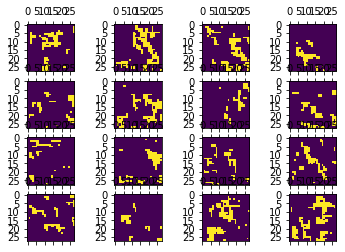

In [6]:
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample_spacial(spacial_2, (28, 28)), (28, 28)))

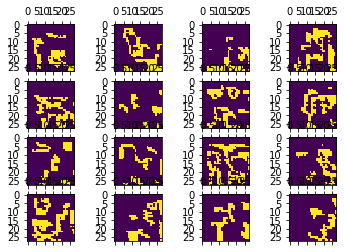

In [7]:
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample_spacial(spacial_4, (28, 28)), (28, 28)))